In [1]:
import spotiphy
import numpy as np
import pandas as pd
import matplotlib as mpl
import scanpy as sc
import squidpy as sq
import importlib as imp

In [2]:
results_folder = 'Results/AD sample 221/'
adata_sc = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/NewMerge_noHarmony.h5ad")
adata_st = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/outs")
adata_st.var_names_make_unique()

adata_sc_orig = adata_sc.copy()
adata_st_orig = adata_st.copy()

key_type = 'majortype'
type_list = sorted(list(adata_sc.obs[key_type].unique()))
print(f'There are {len(type_list)} cell types: {type_list}')

anndata.py (1832): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


There are 27 cell types: ['Astro', 'BCell', 'CA', 'DG', 'Endo', 'L2/3 IT CTX', 'L4 IT CTX', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PT CTX', 'L5/6 IT CTX', 'L5/6 NP CTX', 'L6 CT CTX', 'L6 IT CTX', 'L6b CTX', 'Lamp5', 'Macrophage', 'Microglia', 'Neutrophil', 'Oligo', 'Pvalb', 'SUB', 'Sncg', 'Sst', 'Sst Chodl', 'TCell', 'Vip']


### Deconvolution

In [4]:
adata_sc, adata_st = spotiphy.initialization(adata_sc, adata_st, verbose=1)

Convert expression matrix to array: 0.23s
Normalization: 47.73s
Filtering: 73.67s
Find common genes: 3.75s


In [5]:
# adata_sc = adata_sc_orig.copy()
# adata_st = adata_st_orig.copy()
# imp.reload(spotiphy.sc_reference)
# results_folder = 'Results/AD sample 221/Method 10/'

In [6]:
marker_gene_dict = spotiphy.sc_reference.marker_selection(adata_sc, key_type=key_type, return_dict=True, n_select=50,
                                                          threshold_p=0.1, threshold_fold=1.5, q=0.15)
marker_gene = []
marker_gene_label = []
for type_ in type_list:
    marker_gene.extend(marker_gene_dict[type_])
    marker_gene_label.extend([type_]*len(marker_gene_dict[type_]))
marker_gene_df = pd.DataFrame({'gene':marker_gene, 'label':marker_gene_label})
marker_gene_df.to_csv(results_folder+'marker_gene.csv')
adata_sc = adata_sc[:, marker_gene]
adata_st = adata_st[:, marker_gene]

27it [00:00, 32.65it/s]


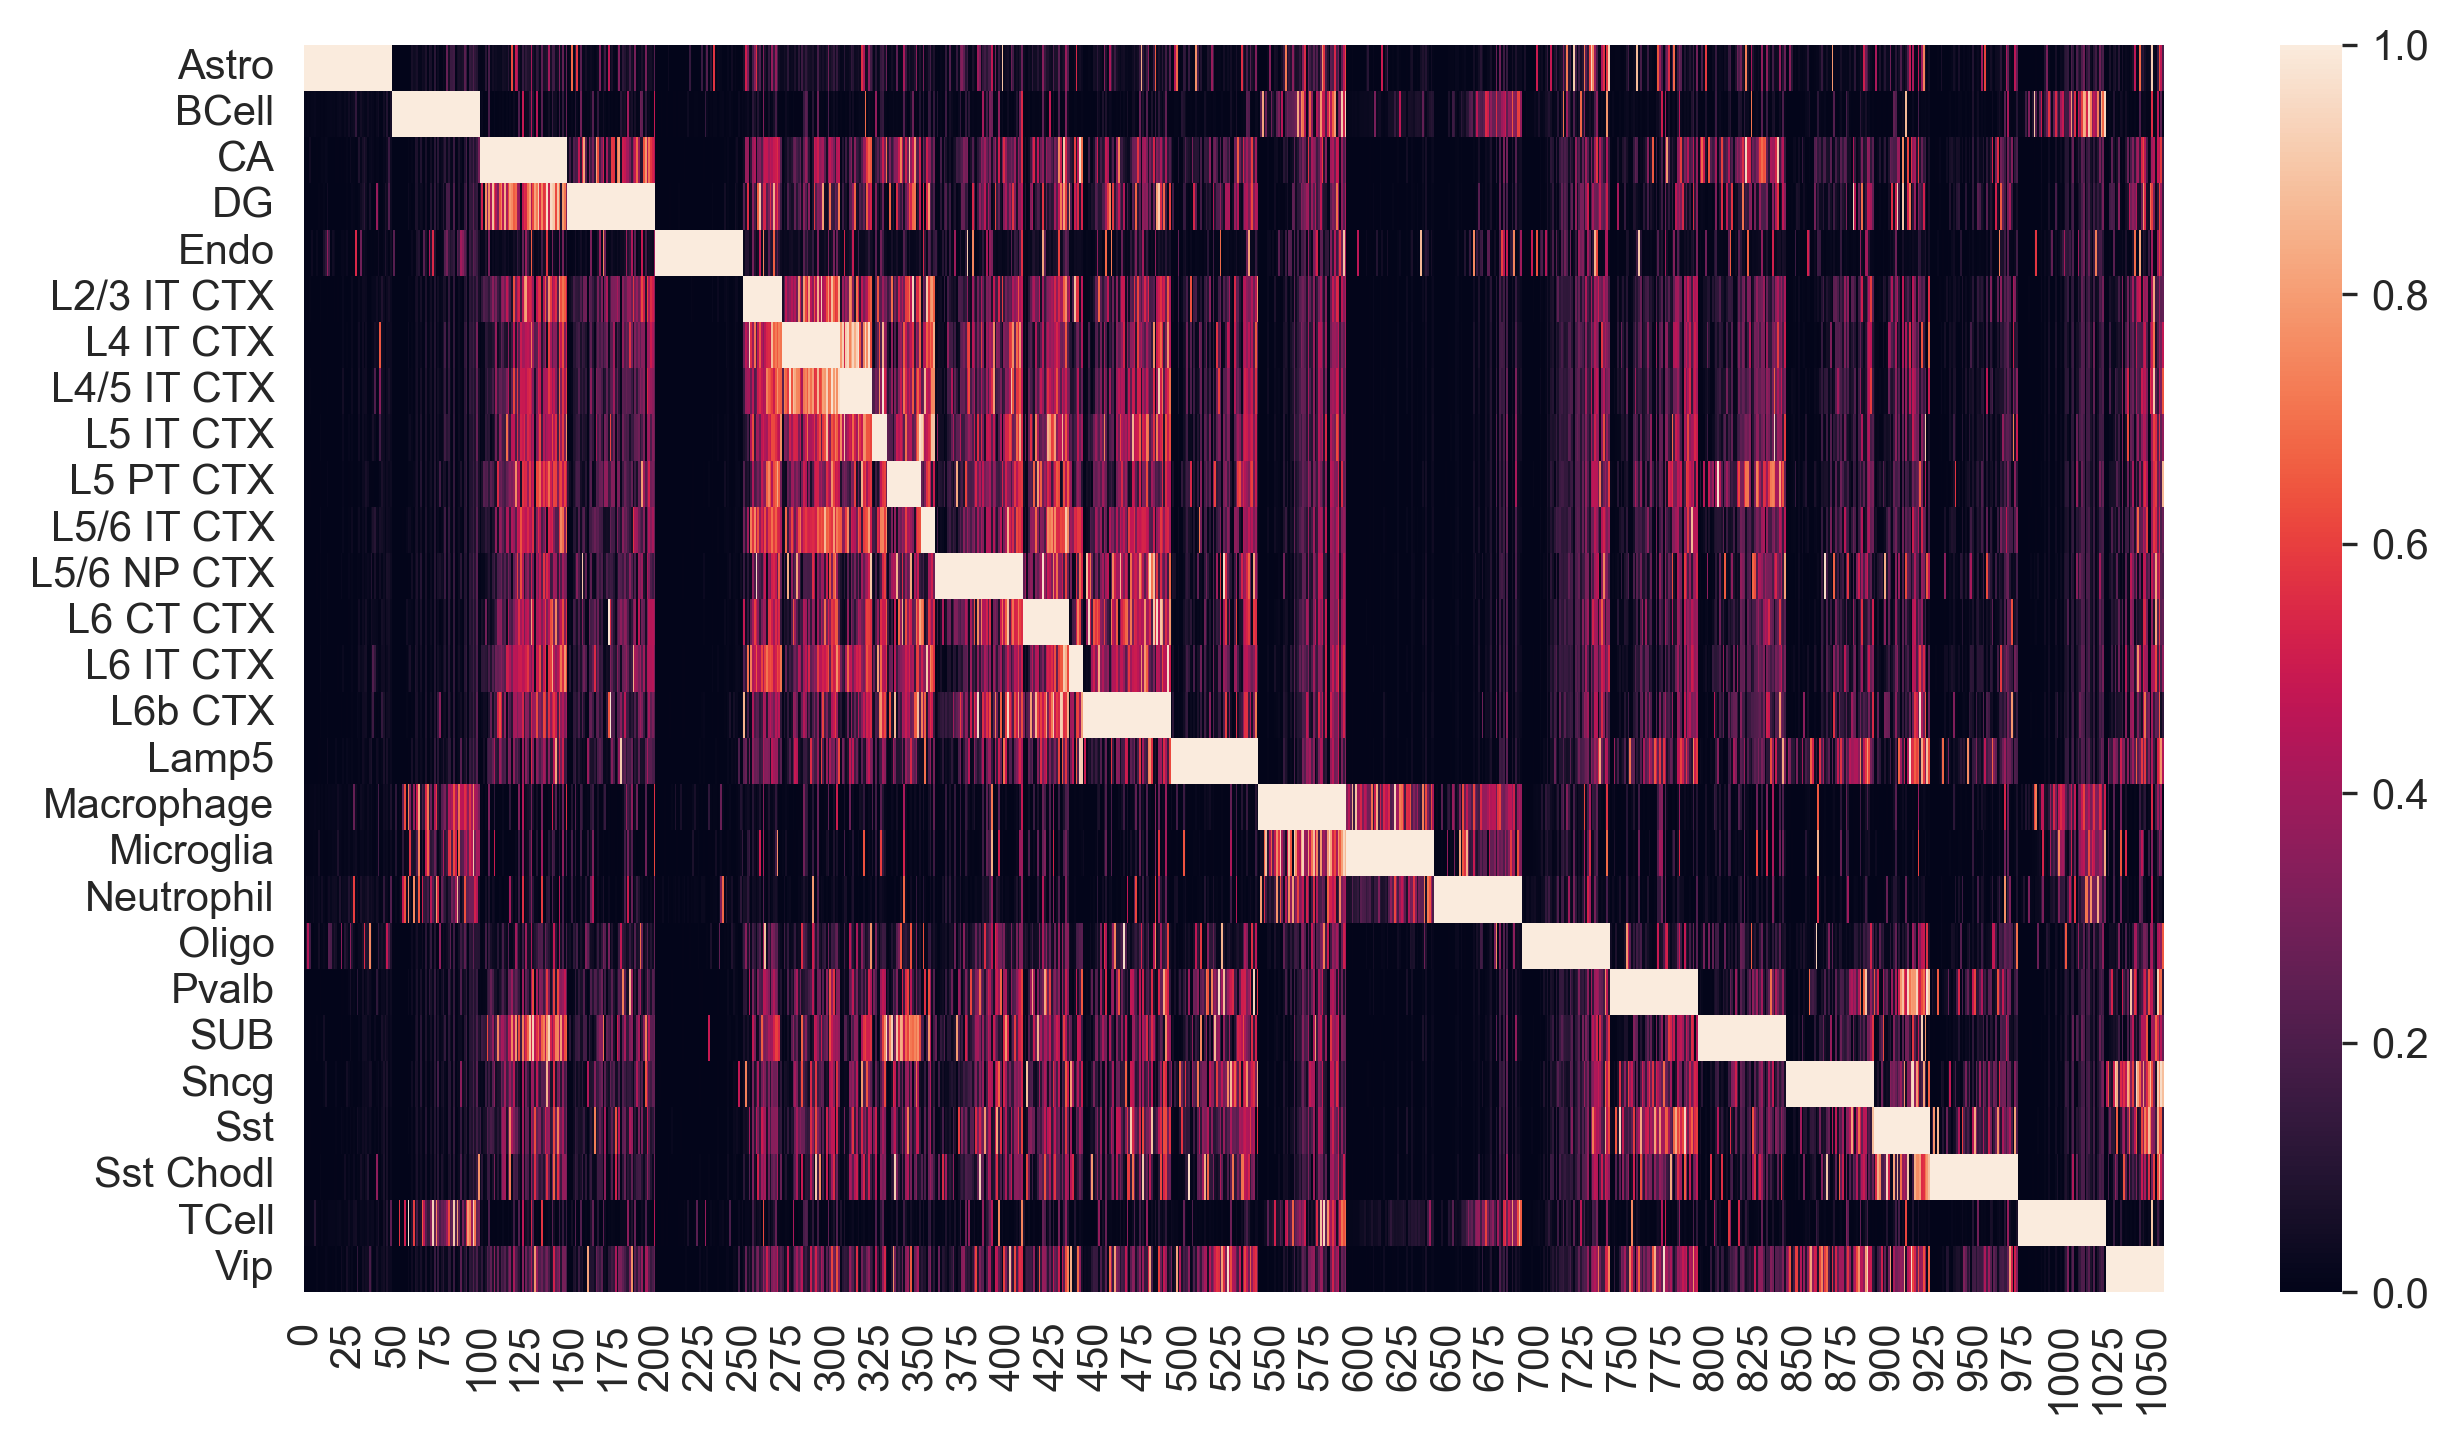

CPU times: total: 18.7 s
Wall time: 18.7 s


In [5]:
sc_ref = spotiphy.construct_sc_ref(adata_sc, key_type=key_type)
spotiphy.sc_reference.plot_heatmap(adata_sc, key_type, save=True, out_dir=results_folder)

In [76]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# ST = adata_st.X
# ST = np.sum(ST, axis=0)
# ST = ST/np.sum(ST)
# plt.figure(figsize=(20,8), dpi=300)
# sc_ref_df = pd.DataFrame(np.vstack([sc_ref, ST]), index=type_list+['ST'])
# ax = sns.heatmap(sc_ref_df, robust=True)
# plt.savefig(results_folder+'heatmap.jpg', bbox_inches='tight')

100%|██████████| 8000/8000 [04:21<00:00, 30.59it/s]


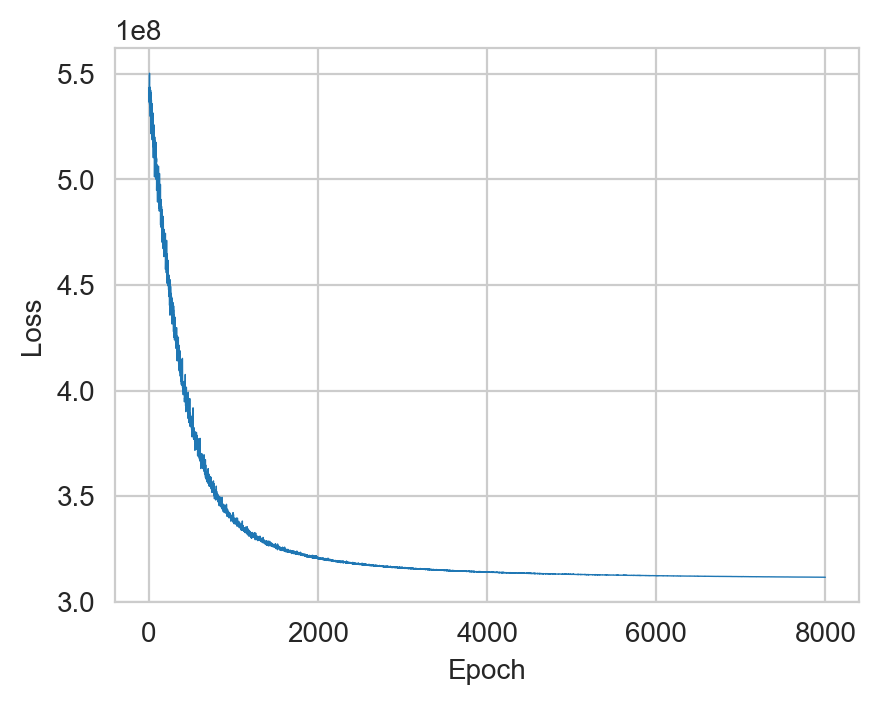

1521618971.py (8): Trying to modify attribute `.obs` of view, initializing view as actual.


In [6]:
X = np.array(adata_st.X)
pyro_params = spotiphy.deconvolution.deconvolute(X, sc_ref, n_epoch=8000, plot=True, batch_prior=1)
sigma = pyro_params['sigma'].cpu().detach().numpy()
mean_exp = np.array([np.mean(np.sum(adata_sc.X[adata_sc.obs[key_type]==type_list[i]], axis=1))
                     for i in range(len(type_list))])
cell_proportion = sigma/mean_exp
cell_proportion = cell_proportion/np.sum(cell_proportion, axis=1)[:, np.newaxis]
adata_st.obs[type_list] = cell_proportion
np.save(results_folder+'proportion.npy', cell_proportion)

In [7]:
cell_proportion = np.load(results_folder+'proportion.npy')
adata_st.obs[type_list] = cell_proportion
# type_list_order = ['L2/3 IT CTX', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PT CTX', 'L5/6 NP CTX', 'L6 CT CTX', 'L6b CTX',
#                    'CAs', 'DG', 'Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip', 'Endo', 'Astro', 'Oligo', 'Pericyte',
#                    'Macrophage', 'Microglia', 'Neutrophil', 'TCell', 'BCell']
type_list_order = type_list

In [4]:
img = adata_st.uns['spatial']['NCF221-D']['images']['hires'].copy()
img[np.max(img[:, :, :3], axis=2)-np.min(img[:, :, :3], axis=2)<30/255] = [1., 1., 1., 1.]
adata_st.uns['spatial']['NCF221-D']['images']['hires'] = img.copy()

In [8]:
vmax = np.quantile(adata_st.obs[type_list_order].values, 0.98, axis=0)
vmax[vmax<0.05] = 0.05
adata_st.var.rename(index={'Lamp5': 'Lamp5_g', 'Pvalb': 'Pvalb_g', 'Sst': 'Sst_g', 'Vip': 'Vip_g', 'Sncg': 'Sncg_g'},
                    inplace=True)
with mpl.rc_context({'figure.figsize': [5, 5], 'figure.dpi': 400, 'xtick.labelsize': 0}):
    ax = sc.pl.spatial(adata_st, cmap='viridis', color=type_list_order, img_key='hires', vmin=0, vmax=list(vmax), size=1.3, 
                       show=False, ncols=7, alpha_img=0.4)
    ax[0].get_figure().savefig(results_folder+'test.jpg')

In [13]:
vmax = np.quantile(adata_st.obs[type_list_order].values, 0.97, axis=0)
vmax[vmax<0.05] = 0.05
adata_st.var.rename(index={'Lamp5': 'Lamp5_g', 'Pvalb': 'Pvalb_g', 'Sst': 'Sst_g', 'Vip': 'Vip_g', 'Sncg': 'Sncg_g'},
                    inplace=True)
with mpl.rc_context({'figure.figsize': [4, 4.5], 'figure.dpi': 400}):
    ax = sc.pl.spatial(adata_st, cmap='magma', color=type_list_order, img_key='hires', vmin=0, vmax=list(vmax), ncols=7,
                       size=1.3, show=False)
    ax[0].get_figure().savefig(results_folder+'spotiphy.jpg', bbox_inches='tight')

### Segmentation

In [9]:
img = sq.im.ImageContainer('F:/Ziqian Zheng/Spotiphy_data/ST/Sample216/Sample216.jpg')
Segmentation = spotiphy.segmentation.Segmentation(img['image'][:, :, 0], adata_st.obsm['spatial'], 
                                                  out_dir=results_folder+'segmentation/')
Segmentation.segment_nucleus(save=True)
n_cell_df = Segmentation.n_cell_df

Image.py (3176): Image size (99010000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.


Suppress the output of tensorflow prediction for tensorflow version 2.12.0>=2.9.0.
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


100%|██████████| 64/64 [01:17<00:00,  1.21s/it]


CPU times: total: 26min 37s
Wall time: 1min 42s


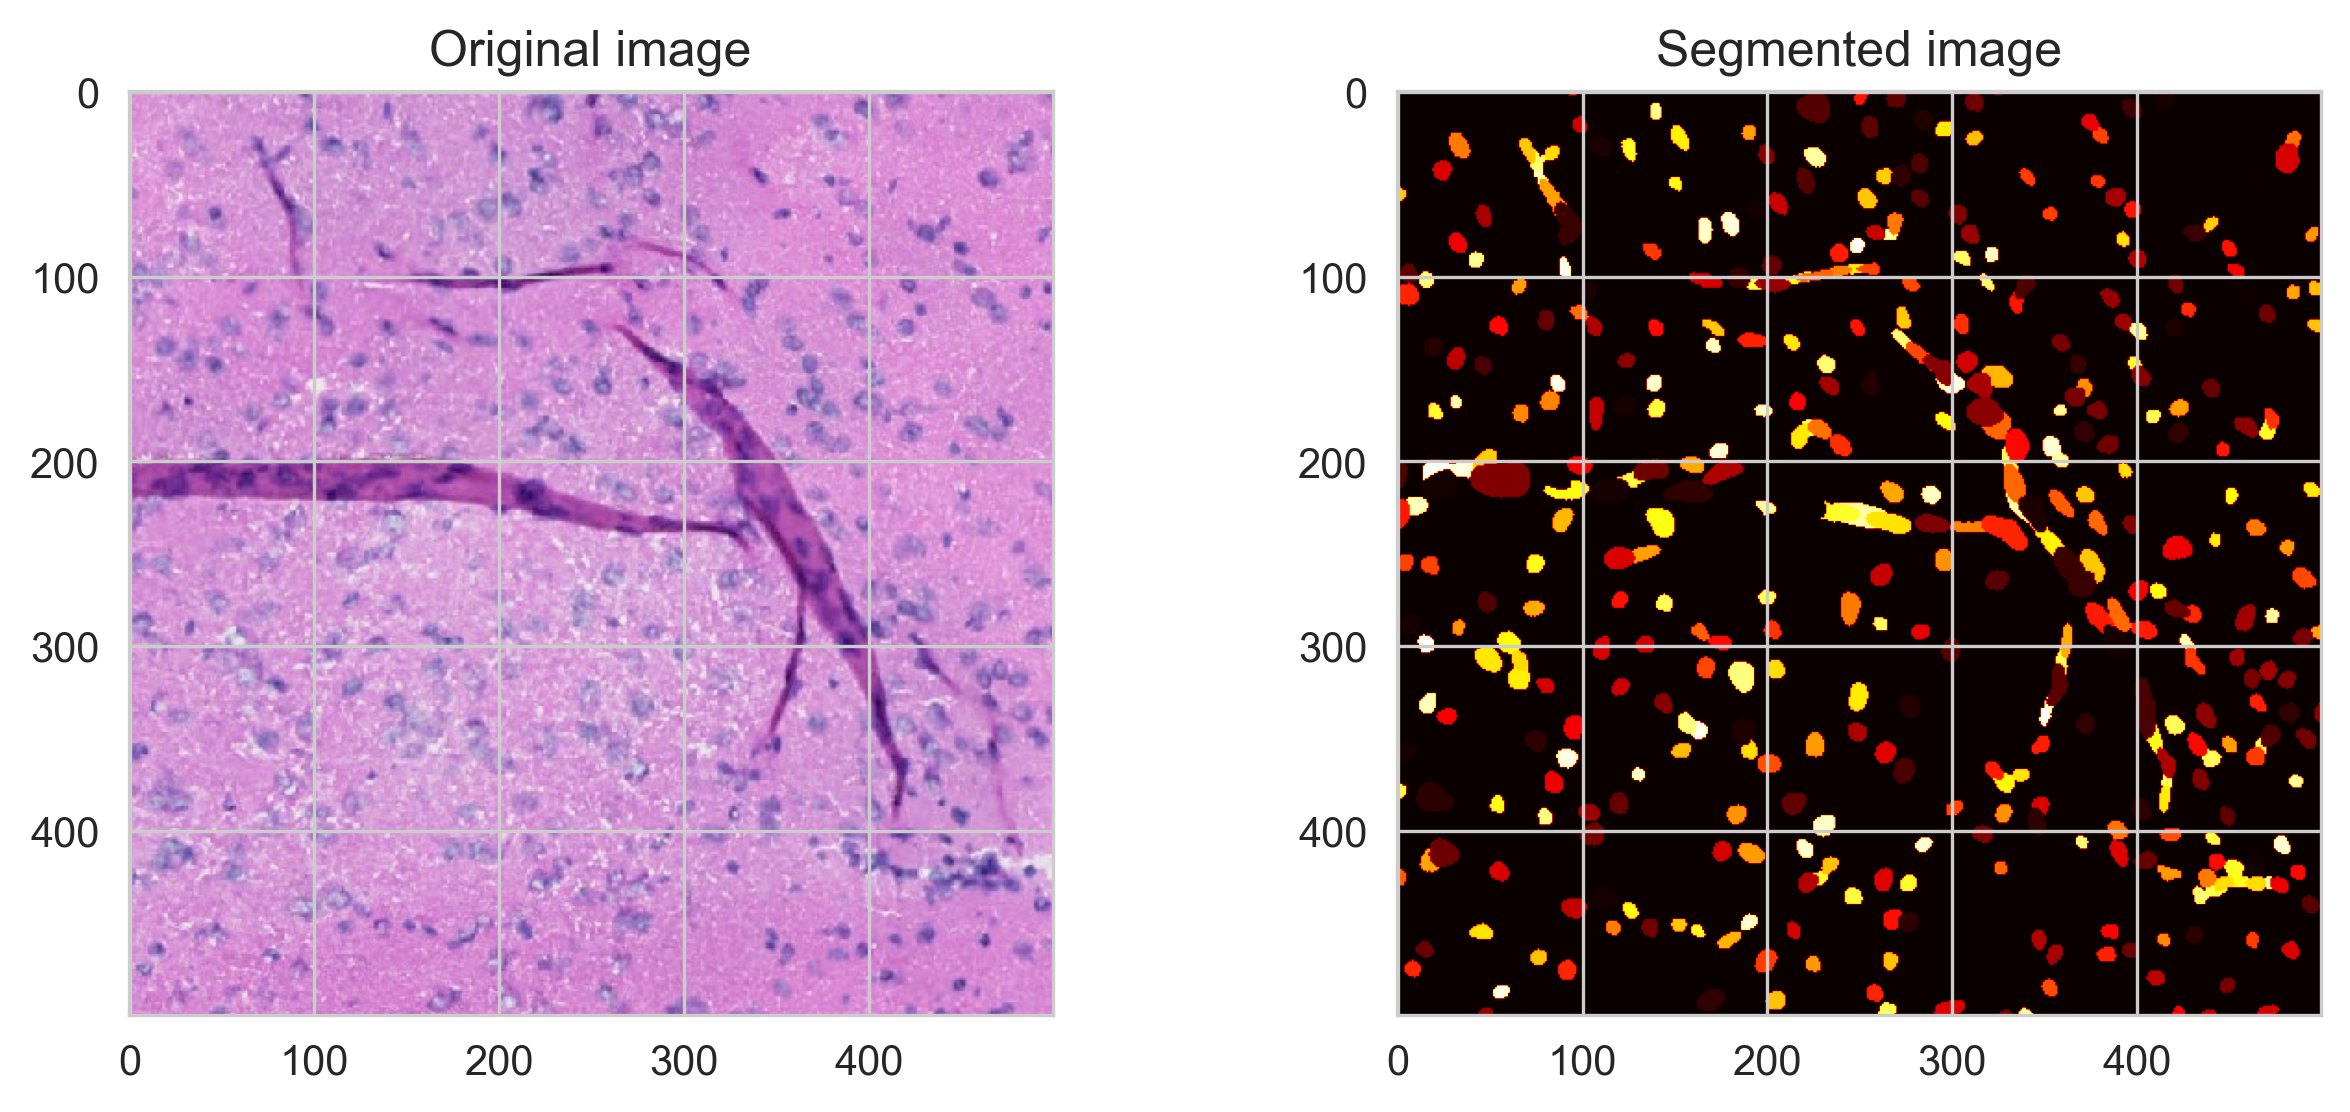

In [10]:
Segmentation.plot(crop=(3000, 3500, 3000, 3500), save=True, path=results_folder+'segmentation/segmentation_sample.jpg')

### Decomposition

In [15]:
cell_proportion = np.load(results_folder+'proportion.npy')
n_cell_df = pd.read_csv(results_folder+'segmentation/n_cell_df.csv', header=0)
n_cell = n_cell_df['cell_count'].values

In [18]:
adata_sc_orig = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/NewMerge_noHarmony.h5ad")
adata_st_orig = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/outs")
adata_st_orig.var_names_make_unique()

anndata.py (1832): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [19]:
adata_st_decomposed = spotiphy.deconvolution.decomposition(adata_st_orig, adata_sc_orig, key_type, cell_proportion, 
                                                           save=True,out_dir=results_folder, verbose=1, 
                                                           spot_location=adata_st.obsm['spatial'], 
                                                           filtering_gene=True, n_cell=n_cell, 
                                                           filename='ST_decomposition_221.h5ad')

Prepared proportion data. Time use 0.19
Initialized scRNA and ST data. Time use 90.70


27it [00:09,  2.84it/s]


Processed scRNA and ST data. Time use 48.75
Decomposition complete. Time use 32.12
Constructed ST decomposition data file. Time use 3.70
Saved file to output folder. Time use 2.22


In [12]:
len(adata_st_decomposed.obs['cell_type'].unique())

25

### Simulated dataset

In [3]:
cell_proportion = np.load(results_folder+'proportion_Sp.npy')
adata_st = adata_st_orig.copy()
adata_sc = adata_sc_orig.copy()
n_cell_df = pd.read_csv(results_folder+'segmentation/n_cell_df.csv', header=0)
adata_st.obs['cell_count'] = n_cell_df['cell_count'].values
adata_st_new = spotiphy.deconvolution.simulation(adata_st, adata_sc, key_type, cell_proportion, n_cell='cell_count', 
                                                 save=True, out_dir=results_folder, filename="ST_Simulated_221_5.h5ad", 
                                                 verbose=1, batch_effect_sigma=0.6, zero_proportion=0.7, 
                                                 additive_noise_sigma=0.4)

Prepared the ground truth. Time use 0.19
Constructed the ground truth. Time use 608.65


_index.py (137): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
deconvolution.py (287): Trying to modify attribute `._uns` of view, initializing view as actual.


Added batch effect, zero reads, and additive noise. Time use 34.03
Saved the simulated data to file. Time use 0.41
